In [ ]:
# Cloning repository with the data for the experiment
# data -> thermalImagesClassificatoin/data/ ...

!git clone https://github.com/rgmantovani/thermalImagesClassification.git

fatal: destination path 'thermalImagesClassification' already exists and is not an empty directory.


In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2 #opencv in pyhton
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [ ]:
# For help: https://github.com/ribeiro-julio/crop-image-classification/blob/main/scripts/04_running_CNN.py

from tensorflow.keras import layers, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

from tensorflow.keras.applications import VGG19, ResNet50

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# For data augmentation
import albumentations as A

In [ ]:
# ----------------------------
# ----------------------------

# constant for experiment
num_classes = 2

# TYPE_OF_IMAGE = "raw"
TYPE_OF_IMAGE = "rgb"
# TYPE_OF_IMAGE = "gray"

# MODEL = "cnn"
# MODEL = "vgg19"
# MODEL = "lwcnn"
MODEL = "resnet"

DATA_AUGMENTATION = True
# DATA_AUGMENTATION = False

# ----------------------------
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
# ----------------------------

SEEDS = [404, 666, 42, 171, 51]
current_seed = SEEDS[4]
print("Seed: ", current_seed)

keras.utils.set_random_seed(current_seed)

Seed:  51


In [ ]:
# data directory
health_dir = "/content/thermalImagesClassification/data/saudaveis"
osteo_dir  = "/content/thermalImagesClassification/data/diagnosticos"

In [ ]:
# loading filepaths
csv_files_health = glob.glob(os.path.join(health_dir, "**","*.csv"),recursive=True)
csv_files_osteo  = glob.glob(os.path.join(osteo_dir, "**", "*.csv"),recursive=True)

In [ ]:
raw_file = csv_files_health[0]
print(raw_file)

/content/thermalImagesClassification/data/saudaveis/tibia_em_pe/Em_pe_101.csv


In [ ]:
# ----------------------------------------------------------------------------
# Creating labels
# ----------------------------------------------------------------------------
Y_healthy = np.zeros(len(csv_files_health))
Y_osteo  = np.ones(len(csv_files_osteo))

# concatenating values
Y = np.concatenate((Y_healthy, Y_osteo))
# print(Y)

# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------

In [ ]:
# --------------------------------------------------------------
# Splitting files into training and testing folds
# --------------------------------------------------------------
all_files = csv_files_health + csv_files_osteo

x_train_files, x_test_files, y_train, y_test = train_test_split(all_files,
    Y, test_size=0.3, random_state=42, stratify=Y)

In [ ]:
print("Tamanho do X_train:", len(x_train_files))
print("Tamanho do X_test:", len(x_test_files))
print("Tamanho do y_train:", y_train.shape)
print("Tamanho do y_test:", y_test.shape)

Tamanho do X_train: 511
Tamanho do X_test: 220
Tamanho do y_train: (511,)
Tamanho do y_test: (220,)


In [ ]:
# --------------------------------------------------------------
# function to plot thermal imagens from raw file
# --------------------------------------------------------------

def plot_csv_image(csv_file):
    data = pd.read_csv(csv_file, header=None)
    image_array = data.to_numpy()
    plt.imshow(image_array, cmap='inferno', interpolation='nearest')
    plt.colorbar()
    plt.show()


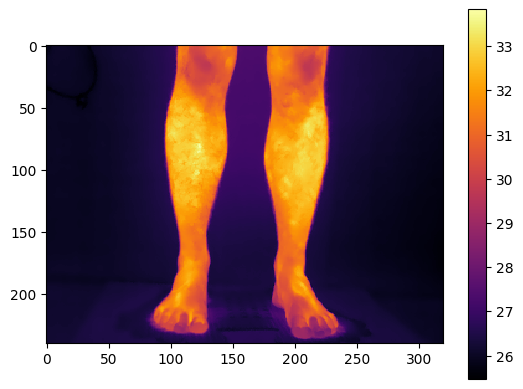

/content/thermalImagesClassification/data/saudaveis/tibia_em_pe/Em_pe_49.csv
0.0


In [ ]:
plot_csv_image(csv_file=x_train_files[0])
# plot_csv_image(csv_file=x_test_files[0])
print(x_test_files[0])
print(y_test[0])

In [ ]:
# --------------------------------------------------------------
# function to load thermal images from csv files
# --------------------------------------------------------------

def load_images_from_csv_files(csv_files):
  if not csv_files:
    raise Exception("No *.csv file was found.")

  raw_images = [pd.read_csv(file).to_numpy() for file in csv_files]
  return(raw_images)


In [ ]:
# --------------------------------------------------------------
# reading images from files
# --------------------------------------------------------------

x_train_images = load_images_from_csv_files(csv_files=x_train_files)
print(x_train_images[0].shape)

x_test_images = load_images_from_csv_files(csv_files=x_test_files)
print(x_test_images[0].shape)


(239, 320)
(239, 320)


In [ ]:
df = pd.DataFrame(x_train_images[0])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
0,25.94025,25.94025,25.84638,25.80985,25.89333,26.06007,26.03924,26.07048,26.08089,26.08610,...,26.13814,26.12773,26.12253,26.10692,26.11212,26.11212,26.11212,26.10692,26.10171,26.10171
1,25.88289,25.89333,25.80464,25.82551,25.96631,26.01841,26.06007,26.07569,26.08089,26.09130,...,26.13814,26.12773,26.11732,26.11212,26.10692,26.10692,26.10692,26.10692,26.10171,26.10171
2,25.90376,25.85682,25.78376,25.89854,25.98715,26.02882,26.06007,26.07569,26.08089,26.09130,...,26.13814,26.12773,26.11732,26.10692,26.10171,26.10692,26.10692,26.10692,26.10171,26.10171
3,25.87246,25.80464,25.86725,25.95588,25.99236,26.02882,26.05486,26.07048,26.08089,26.08610,...,26.13814,26.12773,26.11212,26.10692,26.10171,26.10171,26.10171,26.09651,26.10171,26.10171
4,25.84638,25.86725,25.85682,25.97152,26.00799,26.03403,26.05486,26.06527,26.07569,26.07569,...,26.13293,26.11732,26.10692,26.10171,26.09651,26.10171,26.10171,26.10171,26.10171,26.09651


In [ ]:
# Min and Max temperature values in the raw image
selected_id = 50
print("Image: ", x_train_files[selected_id])
print("Min value: ", np.min(x_train_images[selected_id]))
print("Max value: ", np.max(x_train_images[selected_id]))
print("Mean: ", np.mean(x_train_images[selected_id]))

Image:  /content/thermalImagesClassification/data/diagnosticos/pseudoartrose/pseudoartrose_de_tibia_alongamento_osseo/pessoa01/pessoa01_avaliacao08.csv
Min value:  21.26678
Max value:  34.78566
Mean:  25.28147129327929


In [ ]:
# --------------------------------------------------------------
# normalize image withing [min, max] range
# --------------------------------------------------------------

def normalize(image):
    max = np.amax(image)
    min = np.amin(image)
    normalized_image = (image-min)/(max - min)
    return (normalized_image)

In [ ]:
# -----------------------------------------------
# -----------------------------------------------

def thermal_to_rgb_image(image):
  norm_img = normalize(image = image)
  new_img  = np.round(norm_img * 255)
  u8 = new_img.astype(np.uint8)
  im_color = cv2.applyColorMap(u8, cv2.COLORMAP_JET)
  return(im_color)

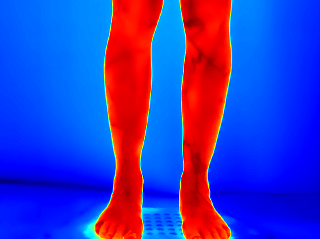

In [ ]:
# example of RGB healthy image
imgc = thermal_to_rgb_image(image = x_train_images[2])
cv2_imshow(imgc)

In [ ]:
imgc.shape

(239, 320, 3)

In [ ]:
# converting all healthy thermal raw images to RGB

if(TYPE_OF_IMAGE == "rgb"):
  print("* Converting thermal images to RGB")
  new_x_train_images = [thermal_to_rgb_image(x) for x in x_train_images]
  new_x_test_images  = [thermal_to_rgb_image(x) for x in x_test_images]
  input_shape = (239, 320, 3)
else:
  print ("* Using raw images - normalized between [0, 1]")
  new_x_train_images = [normalize(x) for x in x_train_images]
  new_x_test_images  = [normalize(x) for x in x_test_images]
  input_shape = (239, 320, 1)
  # print(new_x_train_images[0])

* Converting thermal images to RGB


In [ ]:
# -------------------------------------------
# Creating Training Dataset
# -------------------------------------------
X_train = np.array(new_x_train_images)
X_test  = np.array(new_x_test_images)

In [ ]:
# convert values to the inverval [0, 1]
if(TYPE_OF_IMAGE != "raw"):
  X_train = X_train.astype("float32") / 255
  X_test = X_test.astype("float32") / 255

In [ ]:
# ------------------------------------------------------------
# ------------------------------------------------------------

# TODO: balanceamento no conjunto de treinamento
# Data augmentation da classe minoritaria (quais operacoes)
# usar data augmentation -> https://albumentations.ai/

# descobrir qntas imagens tem 0, e quantas imagens são 1

# ------------------------------------------------------------
# ------------------------------------------------------------

<Axes: ylabel='Frequency'>

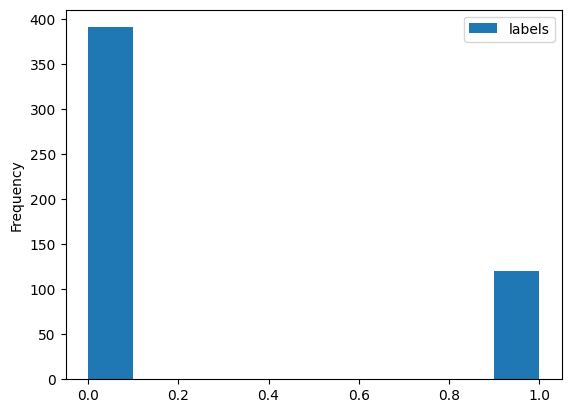

In [ ]:
df_y_train = pd.DataFrame(y_train)
df_y_train.columns = ['labels']
df_y_train.plot.hist()

In [ ]:
# Classical CNN architecture
def get_CNN_model(input_shape):

	CNNmodel = models.Sequential()
	CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
	CNNmodel.add(layers.MaxPooling2D((2, 2)))
	CNNmodel.add(layers.Dropout(0.25))
	CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
	CNNmodel.add(layers.MaxPooling2D((2, 2)))
	CNNmodel.add(layers.Dropout(0.25))
	CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
	CNNmodel.add(layers.Flatten())
	CNNmodel.add(layers.Dense(64, activation='relu'))
	CNNmodel.add(layers.Dropout(0.5))
	CNNmodel.add(layers.Dense(1, activation="sigmoid"))

	return(CNNmodel)

In [ ]:
def get_VGG19_model_Keras(input_shape) :

  VGGmodel = models.Sequential()
  baseModel = VGG19(input_shape=input_shape, weights='imagenet',include_top=False)
  baseModel.trainable = False
  VGGmodel.add(baseModel)
  VGGmodel.add(layers.Flatten())
  VGGmodel.add(layers.Dense(4096,activation = 'relu'))
  VGGmodel.add(layers.Dense(4096,activation = 'relu'))
  VGGmodel.add(layers.Dense(1,activation = 'sigmoid'))
  return(VGGmodel)

In [ ]:
# Light weight convolutional neural network and low-dimensional images transformation approach for classification of thermal images
# https://www.sciencedirect.com/science/article/pii/S2214157X22009078

def get_LW_CNN_model_Taspinar(input_shape):

  LWCNN_model = models.Sequential()
  LWCNN_model.add(layers.Conv2D(6, (5, 5), input_shape=input_shape))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))
  LWCNN_model.add(layers.MaxPooling2D((2, 2)))

  LWCNN_model.add(layers.Conv2D(16, (5, 5)))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))
  LWCNN_model.add(layers.MaxPooling2D((2, 2)))

  LWCNN_model.add(layers.Conv2D(64, (3, 3)))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))
  LWCNN_model.add(layers.MaxPooling2D((2, 2)))

  LWCNN_model.add(layers.Flatten())
  LWCNN_model.add(layers.Dense(128))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))

  LWCNN_model.add(layers.Dropout(0.2))
  LWCNN_model.add(layers.Dense(1, activation="sigmoid"))

  return(LWCNN_model)

In [ ]:
def get_ResNet50_model_Keras(input_shape) :

  ResNetmodel = models.Sequential()
  baseModel = ResNet50(input_shape=input_shape, weights='imagenet',include_top=False)
  baseModel.trainable = True
  ResNetmodel.add(baseModel)
  ResNetmodel.add(layers.GlobalAveragePooling2D())
  ResNetmodel.add(layers.Dense(2,activation = 'softmax'))

  return(ResNetmodel)

In [ ]:
# Defining DL model
match MODEL:
  case "cnn":
    model = get_CNN_model(input_shape=input_shape)
  case "vgg19":
    model = get_VGG19_model_Keras(input_shape=input_shape)
  case "lwcnn":
    model = get_LW_CNN_model_Taspinar(input_shape=input_shape)
  case "resnet":
    model = get_ResNet50_model_Keras(input_shape=input_shape)

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 10, 2048)    │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss=BinaryCrossentropy(),
    metrics=['binary_accuracy', 'accuracy']
)

In [ ]:
if (MODEL == "resnet"):
  y_train = keras.utils.to_categorical(y_train, 2)
  y_test = keras.utils.to_categorical(y_test, 2)

In [ ]:
# ----------------------------
# Traninig the algorithm
# ----------------------------

# Callbacks
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=10, verbose=1)
csv_logger    = CSVLogger(f"log_history_{MODEL}_{TYPE_OF_IMAGE}_seed_{current_seed}.csv", separator=",", append=False)

print(f" - training {MODEL}\n")

history  = model.fit(X_train, y_train, epochs=100, validation_split=0.3, batch_size=16, callbacks=[early_stopper, csv_logger])

 - training resnet

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7461 - binary_accuracy: 0.7461 - loss: 0.4651 - val_accuracy: 0.7662 - val_binary_accuracy: 0.7662 - val_loss: 14.9060
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 275ms/step - accuracy: 0.8804 - binary_accuracy: 0.8804 - loss: 0.3667 - val_accuracy: 0.2338 - val_binary_accuracy: 0.2338 - val_loss: 3677.1221
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.8960 - binary_accuracy: 0.8960 - loss: 0.2260 - val_accuracy: 0.7662 - val_binary_accuracy: 0.7662 - val_loss: 3.9194
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.9070 - binary_accuracy: 0.9070 - loss: 0.1879 - val_accuracy: 0.7662 - val_binary_accuracy: 0.7662 - val_loss: 8.9435
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.8788 - binary_accuracy: 0.8788 - loss: 0.1759 - val_accuracy: 0.7662 - val_binary_accuracy: 0.7662 - val_loss: 131.5657
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 244m

In [ ]:
# ----------------------------
# Evaluating predictions
# ----------------------------
print(" - Evaluating DL model")
predictions = model.predict(X_test)

if(MODEL == "resnet"):
  rounded_predictions = np.argmax(predictions, axis=1)
  y_test = np.argmax(y_test, axis=1)
else:
  rounded_predictions = np.round(predictions)

print(rounded_predictions)

 - Evaluating DL model
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 672ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


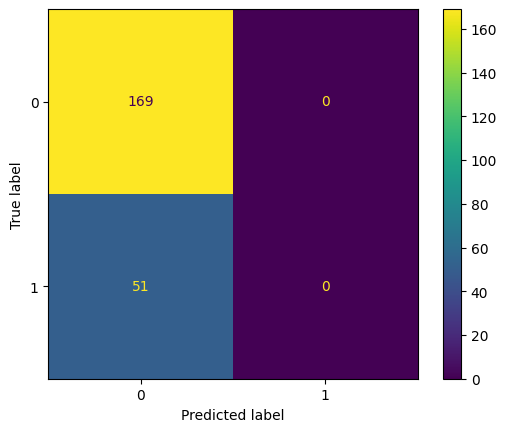

In [ ]:
cm = confusion_matrix(y_test, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
# ----------------------------
# evaluating with scikit learn metrics
# ----------------------------
acc = accuracy_score(y_test, rounded_predictions)
bac = balanced_accuracy_score(y_test, rounded_predictions)
f1s = f1_score(y_test, rounded_predictions)
print("----------------------------")
print("acc = ", acc)
print("bac = ", bac)
print("f1c = ", f1s)
print("----------------------------")

performances = ([acc, bac, f1s, current_seed, TYPE_OF_IMAGE, MODEL])
print(performances)
df_performances = pd.DataFrame(performances).transpose()
df_performances.columns = ['accuracy', 'balanced_accuracy', 'fscore', 'seed', 'type_of_image', 'model']
df_performances.to_csv(f"performances_{MODEL}_{TYPE_OF_IMAGE}_seed_{current_seed}.csv", index = False)
df_performances.head()

----------------------------
acc =  0.7681818181818182
bac =  0.5
f1c =  0.0
----------------------------
[0.7681818181818182, np.float64(0.5), 0.0, 51, 'rgb', 'resnet']


,accuracy,balanced_accuracy,fscore,seed,type_of_image,model
0,0.768182,0.5,0.0,51,rgb,resnet


In [ ]:
# -----------------------------------------------------------
# adding predictions to a data frame
# -----------------------------------------------------------

df_x_test_files = pd.DataFrame(x_test_files)
df_pred  = pd.DataFrame(rounded_predictions)
df_label = pd.DataFrame(y_test)
df_merged = pd.concat([df_x_test_files, df_pred, df_label], axis = 1)
df_merged.columns = ['filepath', 'predictions', 'labels']
df_merged.to_csv(f"predictions_{MODEL}_{TYPE_OF_IMAGE}_seed_{current_seed}.csv", index = False)
df_merged.head()

# -----------------------------------------------------------
# -----------------------------------------------------------

,filepath,predictions,labels
0,/content/thermalImagesClassification/data/saud...,0,0
1,/content/thermalImagesClassification/data/saud...,0,0
2,/content/thermalImagesClassification/data/saud...,0,0
3,/content/thermalImagesClassification/data/saud...,0,0
4,/content/thermalImagesClassification/data/diag...,0,1


In [ ]:
print("Finished !!! :) ")

Finished !!! :) 
